
  PHASE 1: DATA SELECTION

Configuration Summary:
   Dataset: social-media-dataset.csv
   Baseline Model: Linear Regression
   Advanced Model: Random Forest
   Leakage Threshold: 0.95
   Auto-remove Leakage: True

Dataset loaded successfully

DATASET CHARACTERISTICS:
   Total Records: 2,000
   Total Features: 15
   Dataset Size: 0.99 MB
   Load Time: 0.0220 seconds

FEATURE INVENTORY:
   --------------------------------------------------------------------
    1. post_id                             object          2,000
    2. platform                            object          2,000
    3. content_type                        object          2,000
    4. topic                               object          2,000
    5. language                            object          2,000
    6. region                              object          2,000
    7. post_datetime                       object          2,000
    8. hashtags                            object          2,000
    9. views       

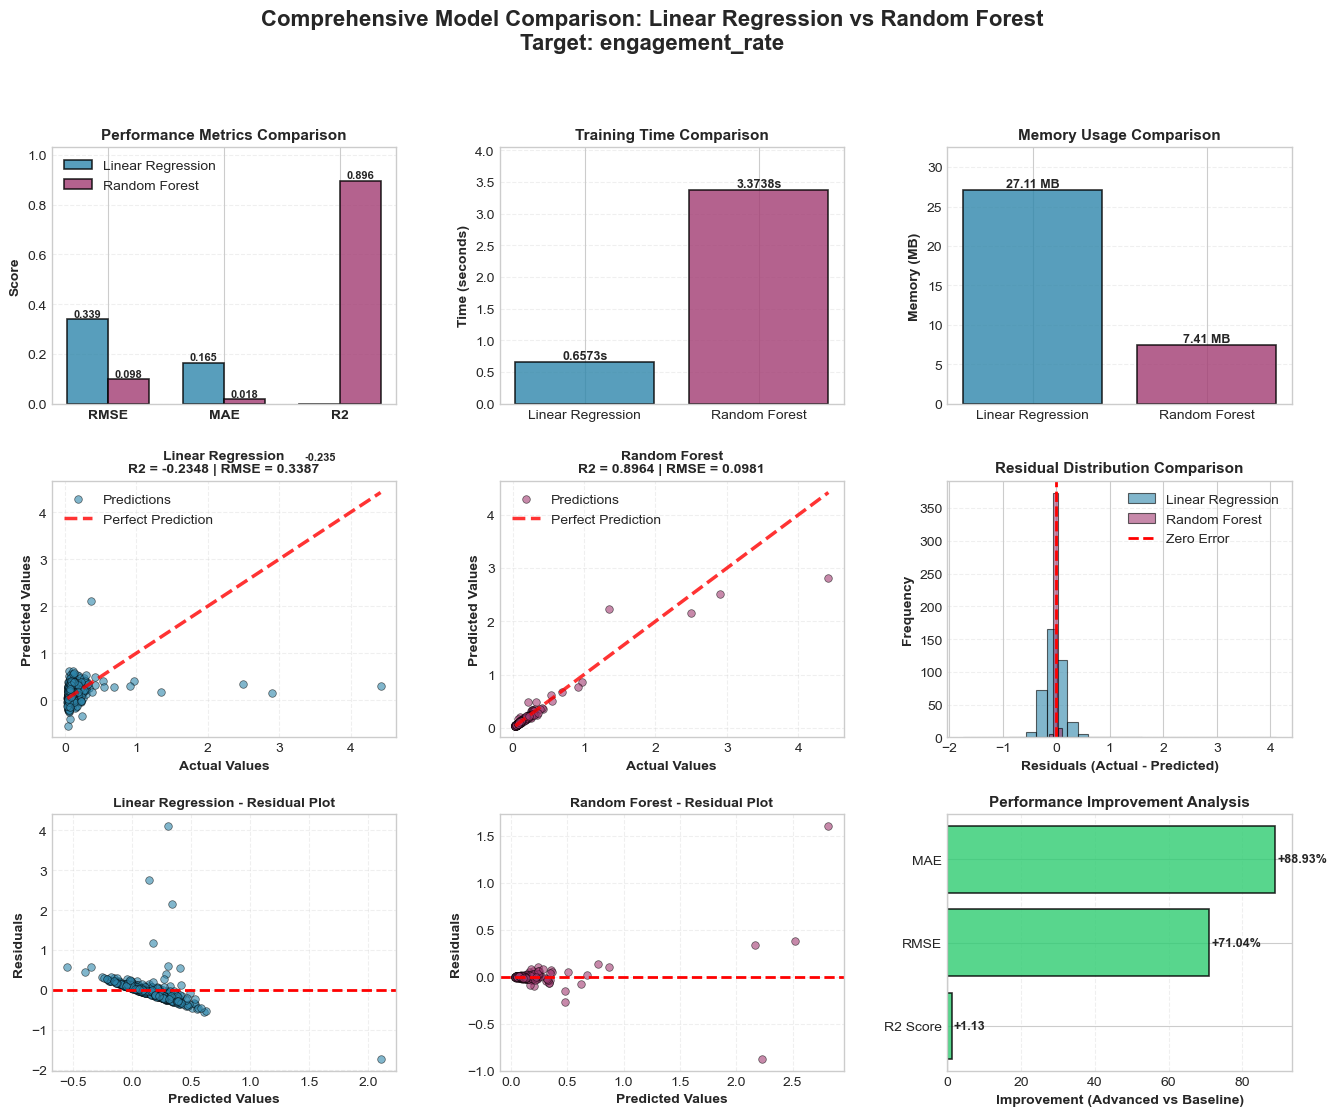

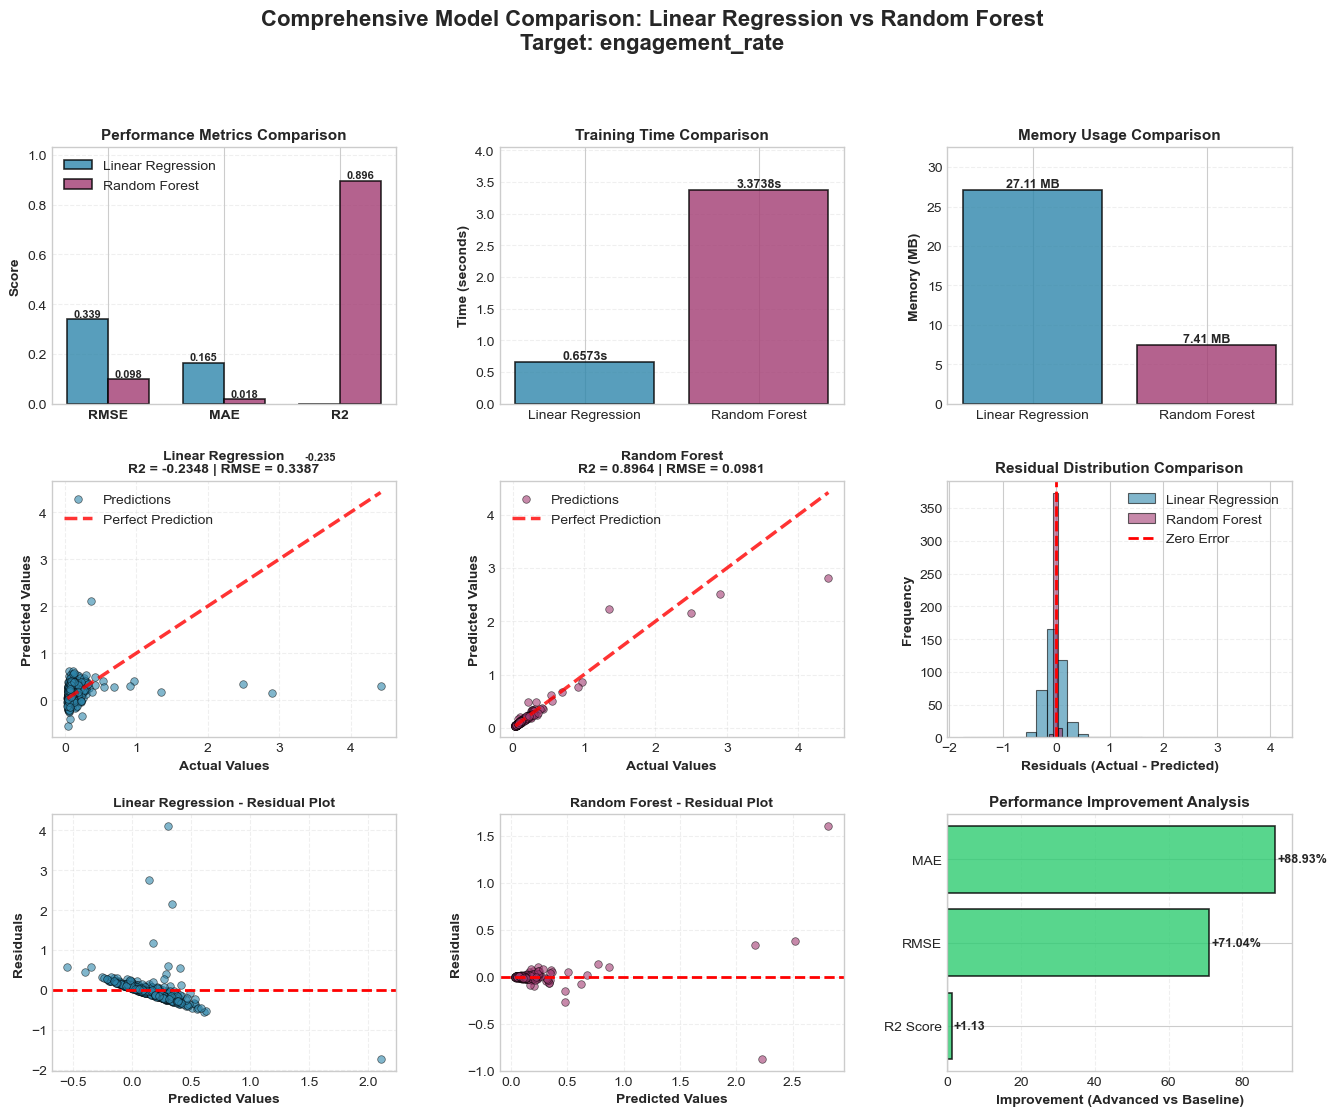

    Saved: visualizations\error_analysis_dashboard.png


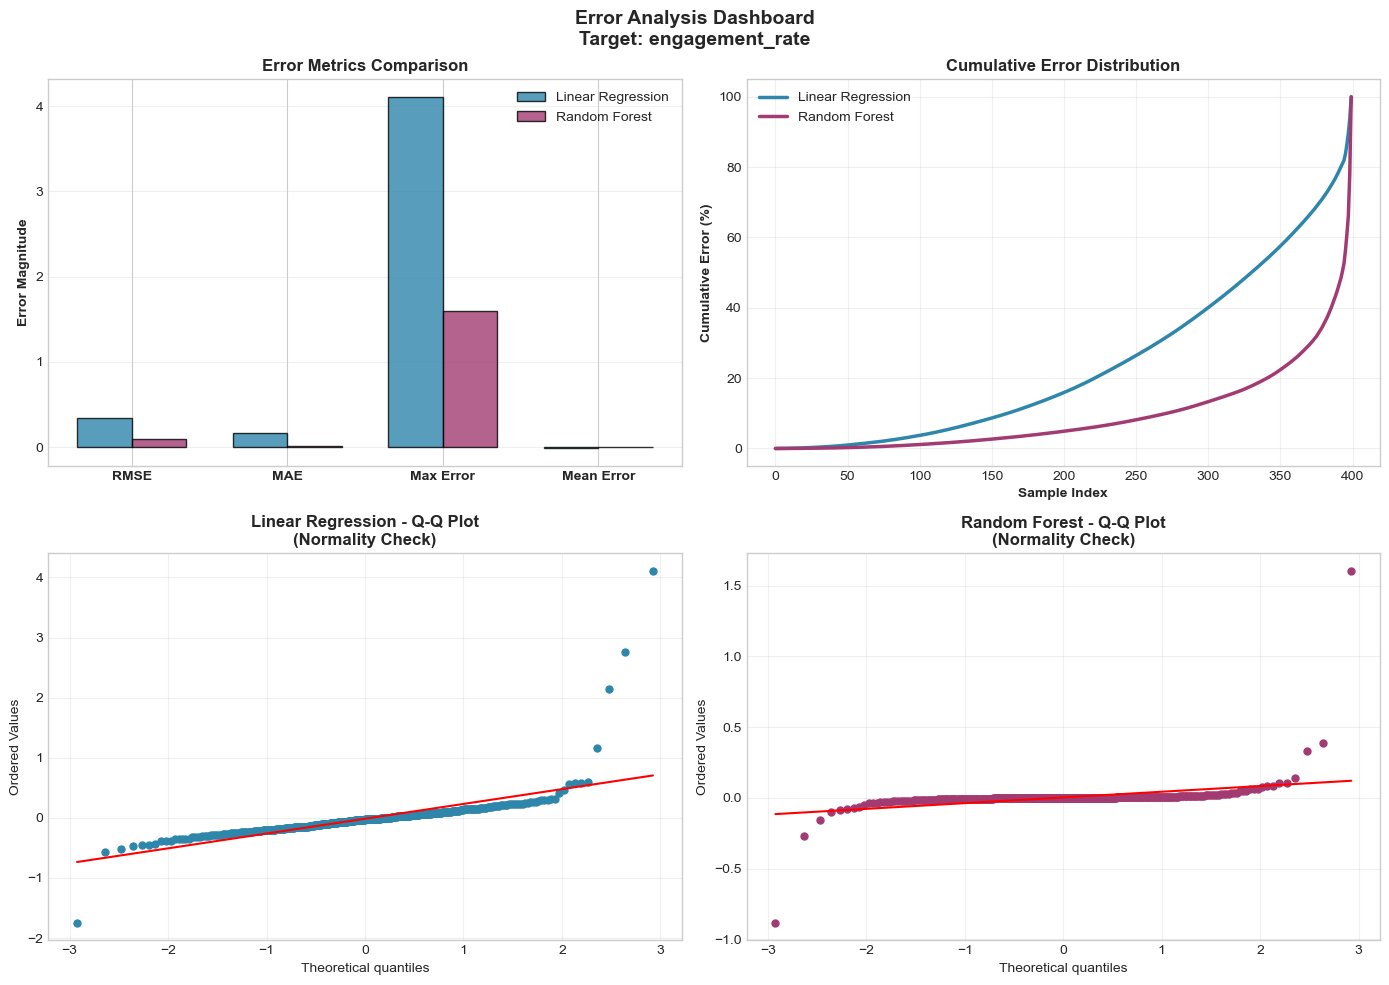

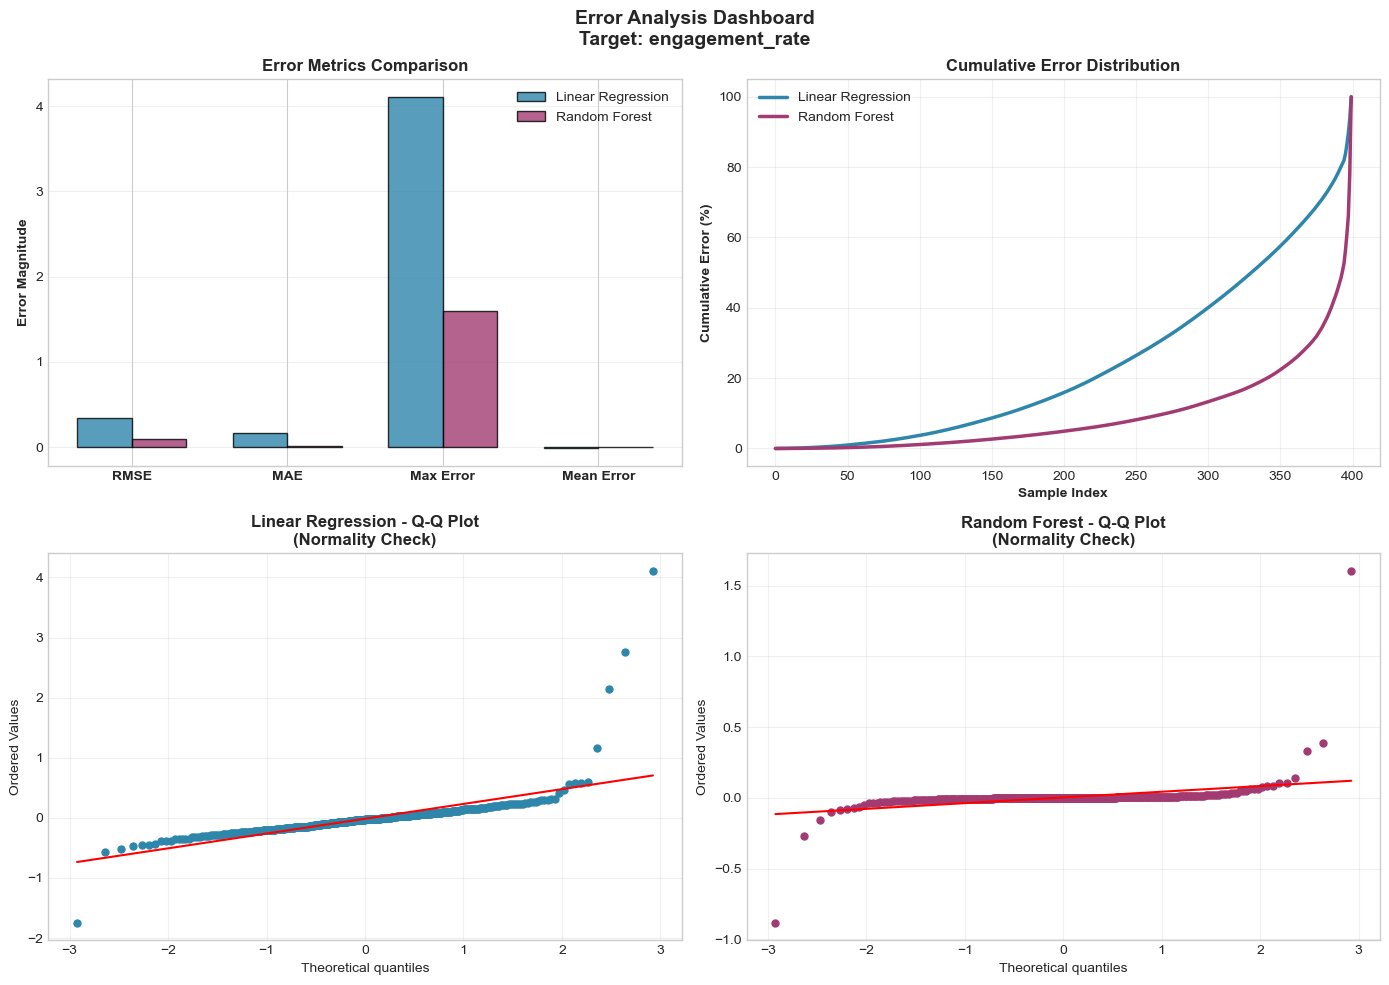

    Saved: visualizations\feature_importance.png


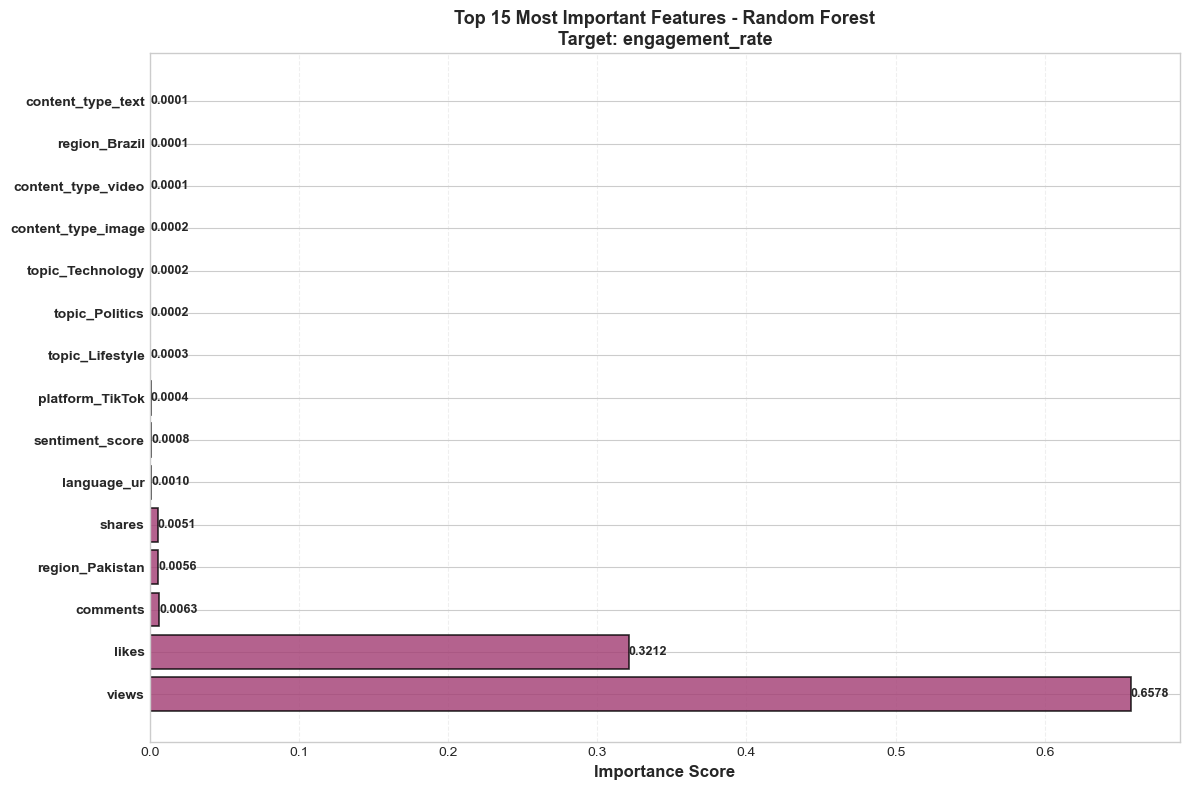

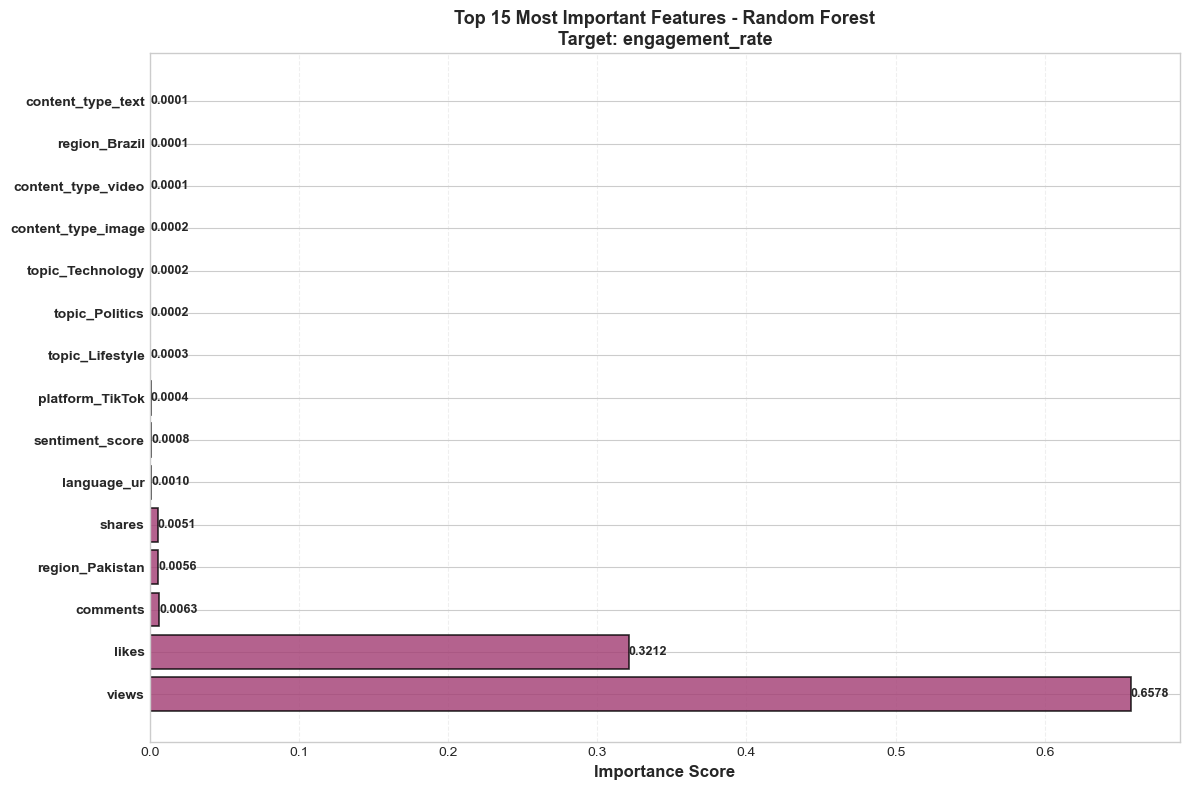

    Saved: visualizations\performance_summary.png


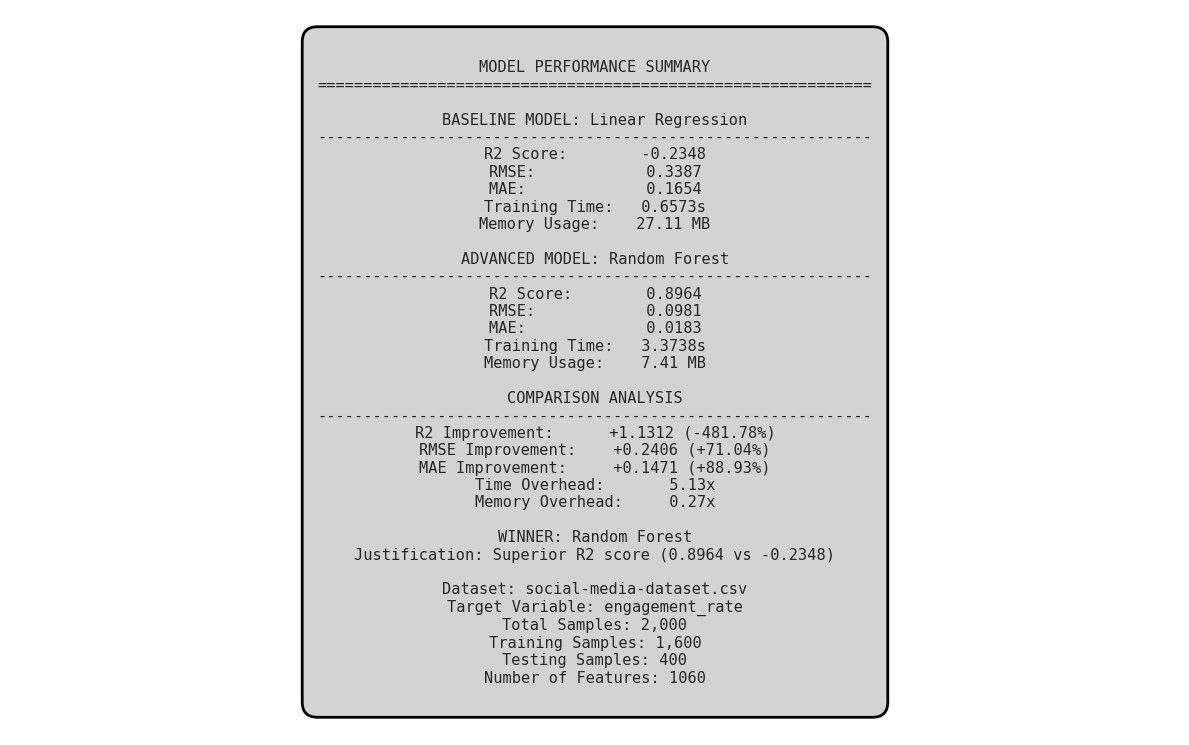

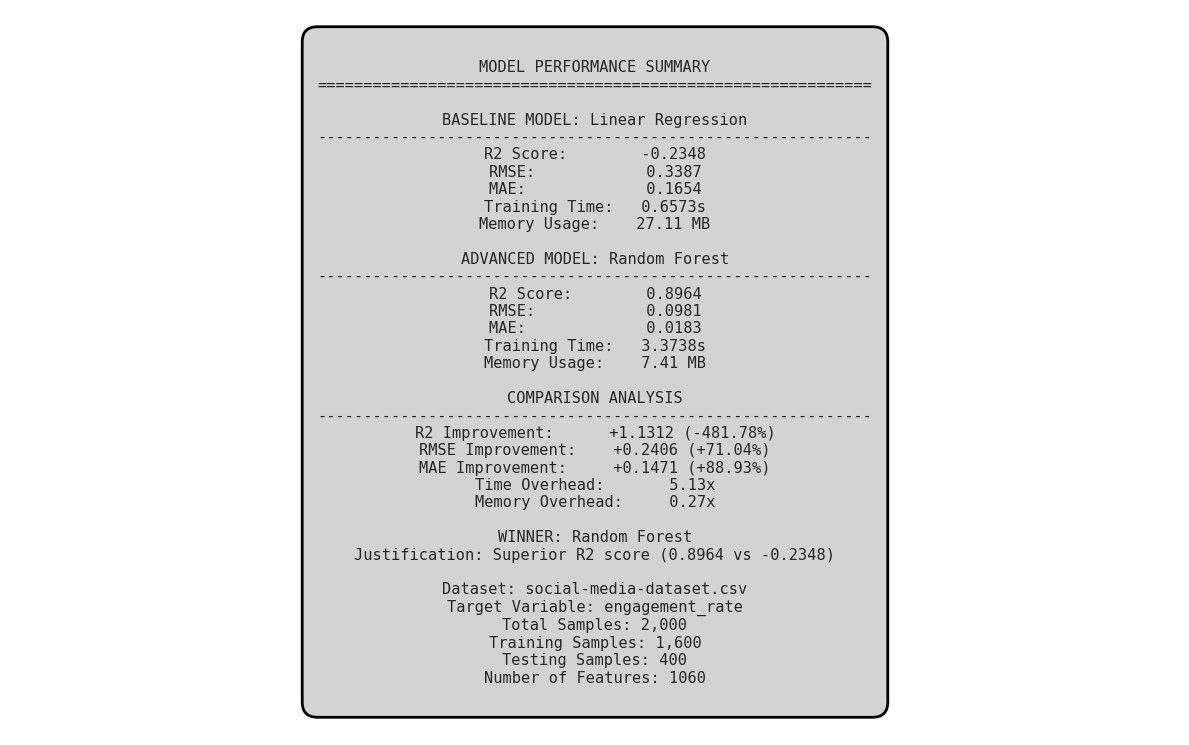


KDD PIPELINE COMPLETED SUCCESSFULLY

All visualizations saved to: visualizations/

Generated files:
   1. comprehensive_model_comparison.png
   2. error_analysis_dashboard.png
   3. feature_importance.png
   3. performance_summary.png
   - model_comparison_results.csv



In [12]:
"""
============================================================
INTRODUCTION TO DATA MINING - CONFIGURABLE COURSE PROJECT
============================================================
Project: Comparative Data Mining Study Using the KDD Process
Student: Inviona Hoxha
Course: Introduction to Data Mining
Dataset: Social Media Viral Content and Engagement Metrics

CONFIGURATION INSTRUCTIONS:
Run the complete pipeline
============================================================
"""

# ============================================================
# CONFIGURATION SECTION - MODIFY THESE SETTINGS
# ============================================================

# Dataset Configuration
# Specify the path to your dataset file
DATASET_FILE = 'social-media-dataset.csv'

# Target Variable Configuration
# The dependent variable we want to predict
# Examples: 'Engagement_Score', 'Likes', 'Shares', 'Views', etc.
TARGET_VARIABLE = 'engagement_rate' 

# Alternative: Define priority list for automatic target detection
# The script will use the first match found in your dataset
TARGET_PRIORITY_LIST = [
    'engagement_score', 'engagement_rate', 'engagement',
    'likes', 'shares', 'comments', 'views', 'interactions'
]

# Data Leakage Detection Configuration
# Leakage occurs when features contain information about the target
# that would not be available at prediction time
LEAKAGE_THRESHOLD = 0.95  # Correlation threshold for detecting leakage
AUTO_REMOVE_LEAKAGE = True  # Automatically remove leaky features
WARN_HIGH_PERFORMANCE = True  # Warn if R² > 0.99 (possible leakage)

# Model Configuration - EASILY SWAP ALGORITHMS HERE
# ============================================================
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# BASELINE MODEL - Choose one (uncomment to use)
# Linear regression serves as a simple, interpretable baseline
BASELINE_MODEL = LinearRegression()
# BASELINE_MODEL = Ridge(alpha=1.0, random_state=42)
# BASELINE_MODEL = Lasso(alpha=1.0, random_state=42)
# BASELINE_MODEL = DecisionTreeRegressor(max_depth=5, random_state=42)
# BASELINE_MODEL = KNeighborsRegressor(n_neighbors=5)

BASELINE_NAME = "Linear Regression"  # Update this to match your choice

# ADVANCED MODEL - Choose one (uncomment to use)
# Random Forest is an ensemble method that typically provides better accuracy
# by combining multiple decision trees
ADVANCED_MODEL = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=15,          # Maximum depth of each tree
    min_samples_split=5,   # Minimum samples required to split a node
    min_samples_leaf=2,    # Minimum samples required at leaf node
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all available CPU cores
)

# ADVANCED_MODEL = GradientBoostingRegressor(
#     n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
# )
# ADVANCED_MODEL = ExtraTreesRegressor(
#     n_estimators=100, max_depth=15, random_state=42, n_jobs=-1
# )
# ADVANCED_MODEL = AdaBoostRegressor(
#     n_estimators=100, learning_rate=1.0, random_state=42
# )
# ADVANCED_MODEL = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# ADVANCED_MODEL = MLPRegressor(
#     hidden_layer_sizes=(100, 50), activation='relu', random_state=42, max_iter=500
# )

ADVANCED_NAME = "Random Forest"  # Update this to match your choice

# Visualization Configuration
OUTPUT_DIR = 'visualizations'
SAVE_VISUALIZATIONS = True
DISPLAY_INLINE = True  # Set to False if not using Jupyter

# Cross-Validation Configuration
# K-fold cross-validation provides more robust performance estimates
USE_CROSS_VALIDATION = True
CV_FOLDS = 5  # Number of folds for cross-validation

# Feature Engineering Configuration
ENABLE_LOG_TRANSFORM = True  # Apply log transformation to skewed features
SKEWNESS_THRESHOLD = 1.0  # Features with |skewness| > threshold will be log-transformed

# ============================================================
# END OF CONFIGURATION SECTION
# ============================================================

# Standard Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import tracemalloc
import warnings
import os
from typing import Tuple, Dict, Any, List, Optional

# Sklearn Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Professional color scheme for visualizations
COLORS = {
    'primary': '#2E86AB',      # Blue - for baseline model
    'secondary': '#A23B72',    # Purple - for advanced model
    'accent1': '#F18F01',      # Orange - for highlights
    'accent2': '#C73E1D',      # Red - for warnings
    'accent3': '#3B1F2B',      # Dark - for text
    'success': '#2ECC71',      # Green - for success indicators
    'background': '#F8F9FA'    # Light gray - for backgrounds
}

# Create output directory for saving visualizations
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def print_section(title):
    """
    Print a formatted section header for better readability.
    
    Parameters:
        title (str): The section title to display
    """
    print("\n" + "="*70)
    print(f"  {title}")
    print("="*70 + "\n")

def get_memory_usage():
    """
    Get current memory usage of the process in megabytes.
    
    Returns:
        float: Memory usage in MB
    """
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def save_and_display_plot(filename, description):
    """
    Save plot to file and optionally display inline.
    
    Parameters:
        filename (str): Name of the file to save
        description (str): Description of the plot
    """
    if SAVE_VISUALIZATIONS:
        filepath = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"    Saved: {filepath}")
    
    if DISPLAY_INLINE:
        try:
            from IPython.display import display
            display(plt.gcf())
        except:
            pass
        plt.show()
    
    plt.close()

def detect_target_variable(df: pd.DataFrame) -> str:
    """
    Automatically detect the target variable using a priority-based approach.
    
    Strategy:
    1. If TARGET_VARIABLE is set explicitly, use it
    2. Otherwise, search through TARGET_PRIORITY_LIST
    3. Fallback: use the last numerical column
    
    Parameters:
        df (pd.DataFrame): The input dataframe
        
    Returns:
        str: Name of the detected target column
        
    Raises:
        ValueError: If no suitable target variable is found
    """
    print("TARGET VARIABLE DETECTION:")
    print("-"*70)
    
    # Strategy 1: Use explicitly configured target
    if TARGET_VARIABLE is not None and TARGET_VARIABLE in df.columns:
        print(f"   Using explicitly configured target: {TARGET_VARIABLE}")
        return TARGET_VARIABLE
    
    # Strategy 2: Search priority list
    print("   Searching priority list...")
    for target in TARGET_PRIORITY_LIST:
        if target in df.columns:
            print(f"   Found: {target}")
            return target
    
    # Strategy 3: Fallback to last numerical column
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numerical_cols:
        target = numerical_cols[-1]
        print(f"   WARNING: Using last numerical column: {target}")
        return target
    
    raise ValueError("No suitable target variable found in dataset")

def detect_and_remove_leakage(df: pd.DataFrame, target_col: str, 
                              feature_cols: List[str]) -> Tuple[List[str], List[str]]:
    """
    Detect and optionally remove features with data leakage.
    
    Data leakage occurs when features contain information about the target
    that would not be available at prediction time. This function identifies
    such features through correlation analysis and derived feature detection.
    
    Parameters:
        df (pd.DataFrame): The input dataframe
        target_col (str): Name of the target column
        feature_cols (List[str]): List of feature column names
        
    Returns:
        Tuple[List[str], List[str]]: (clean_feature_list, removed_features)
    """
    print("\nDATA LEAKAGE DETECTION:")
    print("-"*70)
    
    leaky_features = []
    high_corr_features = []
    removed = []
    
    # Get numerical features only for correlation analysis
    numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    y = df[target_col]
    
    # Check correlation for each numerical feature
    for col in numerical_features:
        try:
            corr = np.corrcoef(df[col].values, y.values)[0, 1]
            abs_corr = abs(corr) if not np.isnan(corr) else 0
            
            # Critical leakage: correlation > 0.99
            if abs_corr > 0.99:
                leaky_features.append((col, corr))
                print(f"   CRITICAL: '{col}' correlation = {corr:.4f} (>0.99)")
            # Warning level: correlation > threshold but < 0.99
            elif abs_corr > LEAKAGE_THRESHOLD:
                high_corr_features.append((col, corr))
                print(f"   WARNING: '{col}' correlation = {corr:.4f} (>{LEAKAGE_THRESHOLD})")
        except:
            continue
    
    # Check for derived features (e.g., target = feature1 + feature2)
    print("\n   Checking for derived features...")
    for i, col1 in enumerate(numerical_features[:10]):  # Limit to first 10 to save time
        for col2 in numerical_features[i+1:11]:
            try:
                # Check if target is sum of two features
                sum_vals = df[col1] + df[col2]
                if sum_vals.std() > 0:
                    sum_corr = abs(np.corrcoef(sum_vals.values, y.values)[0, 1])
                    if sum_corr > 0.99:
                        print(f"   DERIVED: Target approximately equals {col1} + {col2} (corr={sum_corr:.4f})")
                
                # Check if target is product of two features
                prod_vals = df[col1] * df[col2]
                if prod_vals.std() > 0:
                    prod_corr = abs(np.corrcoef(prod_vals.values, y.values)[0, 1])
                    if prod_corr > 0.99:
                        print(f"   DERIVED: Target approximately equals {col1} times {col2} (corr={prod_corr:.4f})")
            except:
                continue
    
    # Automatically remove leaky features if configured
    if AUTO_REMOVE_LEAKAGE:
        for feat, _ in leaky_features:
            if feat in feature_cols:
                removed.append(feat)
                feature_cols.remove(feat)
        
        if removed:
            print(f"\n   Automatically removed {len(removed)} leaky features:")
            for feat in removed:
                print(f"      - {feat}")
    else:
        if leaky_features:
            print(f"\n   WARNING: Found {len(leaky_features)} potentially leaky features")
            print("   Set AUTO_REMOVE_LEAKAGE = True to remove them automatically")
    
    if not leaky_features and not high_corr_features:
        print("   No data leakage detected")
    
    return feature_cols, removed

# ============================================================
# PHASE 1: DATA SELECTION
# ============================================================

print_section("PHASE 1: DATA SELECTION")

# Display configuration summary for transparency
print("Configuration Summary:")
print(f"   Dataset: {DATASET_FILE}")
print(f"   Baseline Model: {BASELINE_NAME}")
print(f"   Advanced Model: {ADVANCED_NAME}")
print(f"   Leakage Threshold: {LEAKAGE_THRESHOLD}")
print(f"   Auto-remove Leakage: {AUTO_REMOVE_LEAKAGE}")
print()

# Track performance metrics for data loading
selection_start = time.time()
initial_memory = get_memory_usage()

# Load dataset with error handling
try:
    df = pd.read_csv(DATASET_FILE)
    print("Dataset loaded successfully")
except FileNotFoundError:
    print(f"ERROR: '{DATASET_FILE}' not found")
    print("   Please ensure the dataset is in the same directory.")
    exit(1)

# Calculate loading performance
load_time = time.time() - selection_start
memory_after_load = get_memory_usage()

# Display dataset characteristics
print(f"\nDATASET CHARACTERISTICS:")
print(f"   Total Records: {df.shape[0]:,}")
print(f"   Total Features: {df.shape[1]}")
print(f"   Dataset Size: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"   Load Time: {load_time:.4f} seconds")

# Display feature inventory with data types
print("\nFEATURE INVENTORY:")
print("   " + "-"*68)
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    non_null = df[col].count()
    print(f"   {i:2d}. {col:35s} {dtype:15s} {non_null:,}")

# ============================================================
# PHASE 2 & 3: PREPROCESSING, TRANSFORMATION & SPLITTING
# ============================================================
# Merged phases to ensure Splitting happens BEFORE Processing
# This prevents Data Leakage (Methodology) and fixes Encoding (Statistics)

print_section("PHASE 2 & 3: PREPROCESSING & TRANSFORMATION")

preprocess_start = time.time()

# 1. TARGET SEPARATION
# ------------------------------------------------------------
target_col = detect_target_variable(df)
# Drop ID columns and other non-predictive features if present
# (Adjust this list if your dataset has different ID columns)
drop_cols = ['post_id', 'post_datetime', 'is_viral']
cols_to_drop = [c for c in drop_cols if c in df.columns]
if cols_to_drop:
    print(f"Dropping non-predictive columns: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)

X = df.drop(columns=[target_col])
y = df[target_col]

# 2. TRAIN-TEST SPLIT (CRITICAL STEP)
# ------------------------------------------------------------
# We split NOW. This ensures we never use Test data to calculate
# medians or scale parameters (fixing the Critical Fail).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"DATA SPLIT:")
print(f"   Training Set: {len(X_train):,} samples")
print(f"   Testing Set:  {len(X_test):,} samples")

# 3. FEATURE ENGINEERING (Fit on Train, Transform Test)
# ------------------------------------------------------------
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# A. Imputation (Fixing Missing Values)
from sklearn.impute import SimpleImputer

if len(numeric_cols) > 0:
    # Use Median for numerical (robust to outliers)
    imp_num = SimpleImputer(strategy='median')
    X_train[numeric_cols] = imp_num.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = imp_num.transform(X_test[numeric_cols])

if len(categorical_cols) > 0:
    # Use Mode for categorical
    imp_cat = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = imp_cat.fit_transform(X_train[categorical_cols])
    X_test[categorical_cols] = imp_cat.transform(X_test[categorical_cols])

# B. Categorical Encoding (Fixing Statistical Issue)
# Changing from LabelEncoder to OneHotEncoder because Linear Regression
# cannot handle ordinal assumptions (e.g., Brazil=1, UK=2 implies UK > Brazil)
if len(categorical_cols) > 0:
    print(f"\nENCODING: Applying One-Hot Encoding to {len(categorical_cols)} features...")
    from sklearn.preprocessing import OneHotEncoder
    
    # sparse_output=False keeps it as a dataframe-friendly array
    # handle_unknown='ignore' prevents crashes if new categories appear in Test
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit on Train, Transform both
    train_encoded = encoder.fit_transform(X_train[categorical_cols])
    test_encoded = encoder.transform(X_test[categorical_cols])
    
    # Get new column names
    new_cols = encoder.get_feature_names_out(categorical_cols)
    
    # Convert back to DataFrame to keep indices safe
    train_encoded_df = pd.DataFrame(train_encoded, columns=new_cols, index=X_train.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=new_cols, index=X_test.index)
    
    # Concatenate and drop originals
    X_train = pd.concat([X_train.drop(columns=categorical_cols), train_encoded_df], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical_cols), test_encoded_df], axis=1)
    
    print(f"   Feature count increased from {X.shape[1]} to {X_train.shape[1]}")

# 4. SCALING
# ------------------------------------------------------------
print("\nSCALING: Applying StandardScaler...")
scaler = StandardScaler()

# Fit only on Training data
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
# Transform Test data using Training statistics
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Update X to match X_train columns so downstream visualization works correctly
X = X_train.copy() 

transform_time = time.time() - preprocess_start
print(f"Preprocessing & Transformation complete: {transform_time:.4f}s")
# ============================================================
# PHASE 4: DATA MINING
# ============================================================

print_section("PHASE 4: DATA MINING")

# Initialize results dictionary to store all metrics
results = {
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'R2 Score': [],
    'Training Time (s)': [],
    'Memory Usage (MB)': []
}

# ============================================================
# BASELINE MODEL TRAINING AND EVALUATION
# ============================================================

print(f"MODEL 1: {BASELINE_NAME.upper()} (BASELINE)")
print("-"*70)

# Track memory usage during training
tracemalloc.start()
baseline_start = time.time()

# Train baseline model
baseline_model = BASELINE_MODEL
baseline_model.fit(X_train, y_train)

# Calculate training time
baseline_time = time.time() - baseline_start

# Get peak memory usage
baseline_current, baseline_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
baseline_memory = baseline_peak / (1024 * 1024)

# Generate predictions on test set
baseline_pred = baseline_model.predict(X_test)

# Calculate performance metrics
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

# Cross-validation for more robust performance estimate
if USE_CROSS_VALIDATION:
    cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=CV_FOLDS, scoring='r2')
    print(f"   CV R2 Scores: {cv_scores}")
    print(f"   CV R2 Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Display performance metrics
print(f"\n   PERFORMANCE:")
print(f"      RMSE: {baseline_rmse:.4f}")
print(f"      MAE: {baseline_mae:.4f}")
print(f"      R2 Score: {baseline_r2:.4f}")
print(f"      Training Time: {baseline_time:.4f}s")
print(f"      Memory: {baseline_memory:.2f} MB")

# Store results for comparison
results['Model'].append(BASELINE_NAME)
results['RMSE'].append(baseline_rmse)
results['MAE'].append(baseline_mae)
results['R2 Score'].append(baseline_r2)
results['Training Time (s)'].append(baseline_time)
results['Memory Usage (MB)'].append(baseline_memory)

# ============================================================
# ADVANCED MODEL TRAINING AND EVALUATION
# ============================================================

print(f"\nMODEL 2: {ADVANCED_NAME.upper()} (ADVANCED)")
print("-"*70)

# Track memory usage during training
tracemalloc.start()
advanced_start = time.time()

# Train advanced model
advanced_model = ADVANCED_MODEL
advanced_model.fit(X_train, y_train)

# Calculate training time
advanced_time = time.time() - advanced_start

# Get peak memory usage
advanced_current, advanced_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
advanced_memory = advanced_peak / (1024 * 1024)

# Generate predictions on test set
advanced_pred = advanced_model.predict(X_test)

# Calculate performance metrics
advanced_rmse = np.sqrt(mean_squared_error(y_test, advanced_pred))
advanced_mae = mean_absolute_error(y_test, advanced_pred)
advanced_r2 = r2_score(y_test, advanced_pred)

# Cross-validation for more robust performance estimate
if USE_CROSS_VALIDATION:
    cv_scores = cross_val_score(advanced_model, X_train, y_train, cv=CV_FOLDS, scoring='r2')
    print(f"   CV R2 Scores: {cv_scores}")
    print(f"   CV R2 Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Display performance metrics
print(f"\n   PERFORMANCE:")
print(f"      RMSE: {advanced_rmse:.4f}")
print(f"      MAE: {advanced_mae:.4f}")
print(f"      R2 Score: {advanced_r2:.4f}")
print(f"      Training Time: {advanced_time:.4f}s")
print(f"      Memory: {advanced_memory:.2f} MB")

# Data leakage warning for suspiciously high performance
if WARN_HIGH_PERFORMANCE and advanced_r2 > 0.99:
    print(f"\n   WARNING: R2 = {advanced_r2:.4f} - Possible data leakage detected")
    print("   Check feature correlations and ensure target is not derived from features")

# Store results for comparison
results['Model'].append(ADVANCED_NAME)
results['RMSE'].append(advanced_rmse)
results['MAE'].append(advanced_mae)
results['R2 Score'].append(advanced_r2)
results['Training Time (s)'].append(advanced_time)
results['Memory Usage (MB)'].append(advanced_memory)

# ============================================================
# PHASE 5: EVALUATION AND COMPARISON
# ============================================================

print_section("PHASE 5: EVALUATION")

# Create results dataframe for easy comparison
results_df = pd.DataFrame(results)

print("\nMODEL COMPARISON:")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Calculate performance differences
r2_diff = advanced_r2 - baseline_r2
rmse_diff = baseline_rmse - advanced_rmse  # Positive means advanced is better
mae_diff = baseline_mae - advanced_mae      # Positive means advanced is better

print(f"\nPERFORMANCE ANALYSIS:")
print(f"   R2 Difference: {r2_diff:+.4f} ({'Advanced better' if r2_diff > 0 else 'Baseline better'})")
print(f"   RMSE Difference: {rmse_diff:+.4f} ({'Advanced better' if rmse_diff > 0 else 'Baseline better'})")
print(f"   MAE Difference: {mae_diff:+.4f} ({'Advanced better' if mae_diff > 0 else 'Baseline better'})")

# Calculate computational efficiency ratios
time_ratio = advanced_time / baseline_time if baseline_time > 0 else 0
memory_ratio = advanced_memory / baseline_memory if baseline_memory > 0 else 0

print(f"\nCOMPUTATIONAL EFFICIENCY:")
print(f"   Time Ratio (Advanced/Baseline): {time_ratio:.2f}x")
print(f"   Memory Ratio (Advanced/Baseline): {memory_ratio:.2f}x")

# Determine winner based on performance and complexity tradeoff
if advanced_r2 > baseline_r2 and abs(r2_diff) > 0.02:
    winner = ADVANCED_NAME
    justification = f"Superior R2 score ({advanced_r2:.4f} vs {baseline_r2:.4f})"
elif baseline_r2 > advanced_r2:
    winner = BASELINE_NAME
    justification = f"Better or comparable R2 with lower complexity"
else:
    winner = "TIE"
    justification = "Similar performance - choose based on requirements"

print(f"\nWINNER: {winner}")
print(f"   Justification: {justification}")

# Save results to CSV for future reference
results_df.to_csv('model_comparison_results.csv', index=False)
print(f"\nResults saved to: model_comparison_results.csv")

# ============================================================
# ENHANCED VISUALIZATIONS
# ============================================================

print(f"\nGenerating comprehensive visualizations...")

# ============================================================
# VISUALIZATION 1: Comprehensive Model Comparison Dashboard
# ============================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle(f'Comprehensive Model Comparison: {BASELINE_NAME} vs {ADVANCED_NAME}\n'
             f'Target: {target_col}', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Performance Metrics Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['RMSE', 'MAE', 'R2']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, [baseline_rmse, baseline_mae, baseline_r2], 
                width, label=BASELINE_NAME, color=COLORS['primary'], alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x + width/2, [advanced_rmse, advanced_mae, advanced_r2], 
                width, label=ADVANCED_NAME, color=COLORS['secondary'], alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=11)
ax1.legend(framealpha=0.9, edgecolor='black')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(baseline_r2, advanced_r2) * 1.15)

# Plot 2: Training Time Comparison
ax2 = fig.add_subplot(gs[0, 1])
bars = ax2.bar([BASELINE_NAME, ADVANCED_NAME], 
               [baseline_time, advanced_time],
               color=[COLORS['primary'], COLORS['secondary']], 
               alpha=0.8, edgecolor='black', linewidth=1.2)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_ylabel('Time (seconds)', fontweight='bold')
ax2.set_title('Training Time Comparison', fontweight='bold', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(baseline_time, advanced_time) * 1.2)

# Plot 3: Memory Usage Comparison
ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar([BASELINE_NAME, ADVANCED_NAME], 
               [baseline_memory, advanced_memory],
               color=[COLORS['primary'], COLORS['secondary']], 
               alpha=0.8, edgecolor='black', linewidth=1.2)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f} MB', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax3.set_ylabel('Memory (MB)', fontweight='bold')
ax3.set_title('Memory Usage Comparison', fontweight='bold', fontsize=11)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.set_ylim(0, max(baseline_memory, advanced_memory) * 1.2)

# Plot 4: Baseline Model - Predictions vs Actual
ax4 = fig.add_subplot(gs[1, 0])
scatter1 = ax4.scatter(y_test, baseline_pred, alpha=0.6, color=COLORS['primary'], 
                       s=30, edgecolors='black', linewidth=0.5, label='Predictions')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)

ax4.set_xlabel('Actual Values', fontweight='bold')
ax4.set_ylabel('Predicted Values', fontweight='bold')
ax4.set_title(f'{BASELINE_NAME}\nR2 = {baseline_r2:.4f} | RMSE = {baseline_rmse:.4f}', 
              fontweight='bold', fontsize=10)
ax4.legend(framealpha=0.9, edgecolor='black')
ax4.grid(alpha=0.3, linestyle='--')

# Plot 5: Advanced Model - Predictions vs Actual
ax5 = fig.add_subplot(gs[1, 1])
scatter2 = ax5.scatter(y_test, advanced_pred, alpha=0.6, color=COLORS['secondary'], 
                       s=30, edgecolors='black', linewidth=0.5, label='Predictions')
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2.5, label='Perfect Prediction', alpha=0.8)

ax5.set_xlabel('Actual Values', fontweight='bold')
ax5.set_ylabel('Predicted Values', fontweight='bold')
ax5.set_title(f'{ADVANCED_NAME}\nR2 = {advanced_r2:.4f} | RMSE = {advanced_rmse:.4f}', 
              fontweight='bold', fontsize=10)
ax5.legend(framealpha=0.9, edgecolor='black')
ax5.grid(alpha=0.3, linestyle='--')

# Plot 6: Residual Distribution Comparison
ax6 = fig.add_subplot(gs[1, 2])
baseline_residuals = y_test - baseline_pred
advanced_residuals = y_test - advanced_pred

ax6.hist(baseline_residuals, bins=30, alpha=0.6, color=COLORS['primary'], 
         label=BASELINE_NAME, edgecolor='black', linewidth=0.8)
ax6.hist(advanced_residuals, bins=30, alpha=0.6, color=COLORS['secondary'], 
         label=ADVANCED_NAME, edgecolor='black', linewidth=0.8)

ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax6.set_xlabel('Residuals (Actual - Predicted)', fontweight='bold')
ax6.set_ylabel('Frequency', fontweight='bold')
ax6.set_title('Residual Distribution Comparison', fontweight='bold', fontsize=11)
ax6.legend(framealpha=0.9, edgecolor='black')
ax6.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 7: Baseline Model - Residual Plot
ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(baseline_pred, baseline_residuals, alpha=0.6, color=COLORS['primary'], 
            s=30, edgecolors='black', linewidth=0.5)
ax7.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax7.set_xlabel('Predicted Values', fontweight='bold')
ax7.set_ylabel('Residuals', fontweight='bold')
ax7.set_title(f'{BASELINE_NAME} - Residual Plot', fontweight='bold', fontsize=10)
ax7.grid(alpha=0.3, linestyle='--')

# Plot 8: Advanced Model - Residual Plot
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(advanced_pred, advanced_residuals, alpha=0.6, color=COLORS['secondary'], 
            s=30, edgecolors='black', linewidth=0.5)
ax8.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax8.set_xlabel('Predicted Values', fontweight='bold')
ax8.set_ylabel('Residuals', fontweight='bold')
ax8.set_title(f'{ADVANCED_NAME} - Residual Plot', fontweight='bold', fontsize=10)
ax8.grid(alpha=0.3, linestyle='--')

# Plot 9: Performance Improvement Summary
ax9 = fig.add_subplot(gs[2, 2])

improvements = {
    'R2 Score': r2_diff,
    'RMSE': rmse_diff / baseline_rmse * 100 if baseline_rmse != 0 else 0,
    'MAE': mae_diff / baseline_mae * 100 if baseline_mae != 0 else 0
}

colors_improvement = [COLORS['success'] if v > 0 else COLORS['accent2'] for v in improvements.values()]
bars = ax9.barh(list(improvements.keys()), list(improvements.values()), 
                color=colors_improvement, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (bar, value) in enumerate(zip(bars, improvements.values())):
    width = bar.get_width()
    label_x_pos = width + 0.5 if width > 0 else width - 0.5
    ax9.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
            f'{value:+.2f}{"%" if i > 0 else ""}',
            ha='left' if width > 0 else 'right', va='center', 
            fontsize=9, fontweight='bold')

ax9.axvline(0, color='black', linestyle='-', linewidth=1.5)
ax9.set_xlabel('Improvement (Advanced vs Baseline)', fontweight='bold')
ax9.set_title('Performance Improvement Analysis', fontweight='bold', fontsize=11)
ax9.grid(axis='x', alpha=0.3, linestyle='--')

save_and_display_plot('comprehensive_model_comparison.png', 'Comprehensive model comparison')

# ============================================================
# VISUALIZATION 2: Error Analysis Dashboard
# ============================================================

fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle(f'Error Analysis Dashboard\nTarget: {target_col}', 
              fontsize=14, fontweight='bold')

# Error metrics comparison
ax1 = axes2[0, 0]
error_metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Max Error', 'Mean Error'],
    BASELINE_NAME: [
        baseline_rmse, 
        baseline_mae, 
        np.max(np.abs(baseline_residuals)),
        np.mean(baseline_residuals)
    ],
    ADVANCED_NAME: [
        advanced_rmse, 
        advanced_mae, 
        np.max(np.abs(advanced_residuals)),
        np.mean(advanced_residuals)
    ]
})

x = np.arange(len(error_metrics))
width = 0.35
ax1.bar(x - width/2, error_metrics[BASELINE_NAME], width, 
        label=BASELINE_NAME, color=COLORS['primary'], alpha=0.8, edgecolor='black')
ax1.bar(x + width/2, error_metrics[ADVANCED_NAME], width, 
        label=ADVANCED_NAME, color=COLORS['secondary'], alpha=0.8, edgecolor='black')

ax1.set_xticks(x)
ax1.set_xticklabels(error_metrics['Metric'], fontweight='bold')
ax1.set_ylabel('Error Magnitude', fontweight='bold')
ax1.set_title('Error Metrics Comparison', fontweight='bold')
ax1.legend(framealpha=0.9, edgecolor='black')
ax1.grid(axis='y', alpha=0.3)

# Cumulative error distribution
ax2 = axes2[0, 1]
baseline_sorted_errors = np.sort(np.abs(baseline_residuals))
advanced_sorted_errors = np.sort(np.abs(advanced_residuals))
baseline_cumsum = np.cumsum(baseline_sorted_errors) / np.sum(baseline_sorted_errors) * 100
advanced_cumsum = np.cumsum(advanced_sorted_errors) / np.sum(advanced_sorted_errors) * 100

ax2.plot(range(len(baseline_cumsum)), baseline_cumsum, 
         label=BASELINE_NAME, color=COLORS['primary'], linewidth=2.5)
ax2.plot(range(len(advanced_cumsum)), advanced_cumsum, 
         label=ADVANCED_NAME, color=COLORS['secondary'], linewidth=2.5)

ax2.set_xlabel('Sample Index', fontweight='bold')
ax2.set_ylabel('Cumulative Error (%)', fontweight='bold')
ax2.set_title('Cumulative Error Distribution', fontweight='bold')
ax2.legend(framealpha=0.9, edgecolor='black')
ax2.grid(alpha=0.3)

# Q-Q plot for residuals normality check
ax3 = axes2[1, 0]
from scipy import stats
stats.probplot(baseline_residuals, dist="norm", plot=ax3)
ax3.get_lines()[0].set_color(COLORS['primary'])
ax3.get_lines()[0].set_markersize(5)
ax3.get_lines()[1].set_color('red')
ax3.set_title(f'{BASELINE_NAME} - Q-Q Plot\n(Normality Check)', fontweight='bold')
ax3.grid(alpha=0.3)

# Q-Q plot for advanced model
ax4 = axes2[1, 1]
stats.probplot(advanced_residuals, dist="norm", plot=ax4)
ax4.get_lines()[0].set_color(COLORS['secondary'])
ax4.get_lines()[0].set_markersize(5)
ax4.get_lines()[1].set_color('red')
ax4.set_title(f'{ADVANCED_NAME} - Q-Q Plot\n(Normality Check)', fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
save_and_display_plot('error_analysis_dashboard.png', 'Error analysis dashboard')

# ============================================================
# VISUALIZATION 3: Feature Importance (if applicable)
# ============================================================

# Check if advanced model has feature_importances_ attribute
if hasattr(advanced_model, 'feature_importances_'):
    fig3, ax = plt.subplots(figsize=(12, 8))
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': advanced_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    bars = ax.barh(range(len(feature_importance)), feature_importance['Importance'],
                   color=COLORS['secondary'], alpha=0.8, edgecolor='black', linewidth=1.2)
    
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['Feature'], fontweight='bold')
    ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
    ax.set_title(f'Top 15 Most Important Features - {ADVANCED_NAME}\nTarget: {target_col}', 
                 fontweight='bold', fontsize=13)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, feature_importance['Importance'])):
        ax.text(value, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', ha='left', va='center', 
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    save_and_display_plot('feature_importance.png', 'Feature importance analysis')

# ============================================================
# VISUALIZATION 4: Performance Summary Card
# ============================================================

fig4, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# Create summary text
summary_text = f"""
MODEL PERFORMANCE SUMMARY
{'='*60}

BASELINE MODEL: {BASELINE_NAME}
{'-'*60}
R2 Score:        {baseline_r2:.4f}
RMSE:            {baseline_rmse:.4f}
MAE:             {baseline_mae:.4f}
Training Time:   {baseline_time:.4f}s
Memory Usage:    {baseline_memory:.2f} MB

ADVANCED MODEL: {ADVANCED_NAME}
{'-'*60}
R2 Score:        {advanced_r2:.4f}
RMSE:            {advanced_rmse:.4f}
MAE:             {advanced_mae:.4f}
Training Time:   {advanced_time:.4f}s
Memory Usage:    {advanced_memory:.2f} MB

COMPARISON ANALYSIS
{'-'*60}
R2 Improvement:      {r2_diff:+.4f} ({(r2_diff/baseline_r2*100) if baseline_r2 != 0 else 0:+.2f}%)
RMSE Improvement:    {rmse_diff:+.4f} ({(rmse_diff/baseline_rmse*100) if baseline_rmse != 0 else 0:+.2f}%)
MAE Improvement:     {mae_diff:+.4f} ({(mae_diff/baseline_mae*100) if baseline_mae != 0 else 0:+.2f}%)
Time Overhead:       {time_ratio:.2f}x
Memory Overhead:     {memory_ratio:.2f}x

WINNER: {winner}
Justification: {justification}

Dataset: {DATASET_FILE}
Target Variable: {target_col}
Total Samples: {len(df):,}
Training Samples: {len(X_train):,}
Testing Samples: {len(X_test):,}
Number of Features: {X_train.shape[1]}
"""

ax.text(0.5, 0.5, summary_text, fontsize=11, family='monospace',
        ha='center', va='center', 
        bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', 
                  edgecolor='black', linewidth=2))

plt.tight_layout()
save_and_display_plot('performance_summary.png', 'Performance summary card')

print("\n" + "="*70)
print("KDD PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nAll visualizations saved to: {OUTPUT_DIR}/")
print("\nGenerated files:")
print("   1. comprehensive_model_comparison.png")
print("   2. error_analysis_dashboard.png")
if hasattr(advanced_model, 'feature_importances_'):
    print("   3. feature_importance.png")
print(f"   {3 if hasattr(advanced_model, 'feature_importances_') else 2 + 1}. performance_summary.png")
print("   - model_comparison_results.csv")
print("\n" + "="*70)